# Static Community Detection Using CDLIB and NetworkX - M2V

After calculating similairties and updating the edge list with the values, we will look to execute the well-known Louvain and Leiden community detection algorithms using NetworkX library and CDLIB.

## Importing Edge List w/ Weights to NetworkX

NetworkX's read_weighted_edgelist function expects a simple text file with lines of the form <node1> <node2> <weight>, without headers. Since our data is in CSV format, you'll need to use Pandas (or another method) to load the CSV and adjust it to become readable.

In [1]:
import pandas as pd

edge_list_df = pd.read_csv('New Input/M2V_edge_list_with_similarity.csv')

print(edge_list_df)

       source  target    weight
0          p0      a1  0.752102
1          p0      a2  0.803198
2          p0      a3  0.900095
3          p0      a4  0.682413
4          p0      a5  0.833705
...       ...     ...       ...
51372  p10169   p8094  0.209173
51373  p10169   p7974  0.235403
51374  p10169   p5852  0.265217
51375  p10169  p10113  0.639329
51376  p10169  p10031  0.371488

[51377 rows x 3 columns]


In [2]:
negative_weights = edge_list_df[edge_list_df['weight'] < 0]
print(f"Number of edges with negative weights: {len(negative_weights)}")

Number of edges with negative weights: 1981


Since Louvain is not made to consider negative edge weights, we will rescale the weights such that instead of [-1, 1] being the range, it is now [0, 1], where 0 now represents perfect dissimilarity, 0.5 represents orthogonality, and 1 represents perfect similarity.

In [3]:
edge_list_df['weight'] = (edge_list_df['weight'] + 1) / 2

print(edge_list_df)

       source  target    weight
0          p0      a1  0.876051
1          p0      a2  0.901599
2          p0      a3  0.950047
3          p0      a4  0.841207
4          p0      a5  0.916853
...       ...     ...       ...
51372  p10169   p8094  0.604586
51373  p10169   p7974  0.617701
51374  p10169   p5852  0.632609
51375  p10169  p10113  0.819664
51376  p10169  p10031  0.685744

[51377 rows x 3 columns]


Before we continue with the creation of a graph, NetworkX specifies that an undirected, weighted graph must not have self-loop, parallel edges (A->B, B->A), or duplicate edges.

In [4]:
duplicate_edges = edge_list_df.duplicated(subset=['source', 'target'], keep=False)
print(f"Number of duplicate edges: {duplicate_edges.sum()}")

self_loops = edge_list_df[edge_list_df['source'] == edge_list_df['target']]
print(f"Number of self-loops: {len(self_loops)}")

print(edge_list_df.isnull().sum())

Number of duplicate edges: 0
Number of self-loops: 4
source    0
target    0
weight    0
dtype: int64


In [5]:
print(f"Number of edges before dropping self-loops: {len(edge_list_df)}")

edge_list_df = edge_list_df[edge_list_df['source'] != edge_list_df['target']]

print(f"Number of edges after dropping self-loops: {len(edge_list_df)}")

Number of edges before dropping self-loops: 51377
Number of edges after dropping self-loops: 51373


In [6]:
# Find duplicate edges (ignoring the weight column)
duplicate_edges = edge_list_df.duplicated(subset=['source', 'target'], keep=False)

# Filter to get only the duplicate edges
parallel_edges_df = edge_list_df[duplicate_edges]

# Sort to better visualize parallel edges
parallel_edges_sorted = parallel_edges_df.sort_values(by=['source', 'target'])

print(parallel_edges_sorted)

Empty DataFrame
Columns: [source, target, weight]
Index: []


## Creating Undirected Weighted Graph

We iterate over the edge list DataFrame rows to add edges along with their weights to a new NetworkX graph.


In [7]:
import networkx as nx

def get_graph_info(graph):
    print("Number of nodes:", graph.number_of_nodes())
    print("Number of edges:", graph.number_of_edges())
    
    # Checking the graph type to provide appropriate information
    if isinstance(graph, nx.DiGraph):
        print("Graph is Directed")
    else:
        print("Graph is Undirected")


In [8]:
# Initialize a new graph
G = nx.MultiGraph()

# Add edges and weights
for index, row in edge_list_df.iterrows():
    source = row['source']
    target = row['target']
    weight = row['weight']
    
    # Add the edge with weight
    G.add_edge(source, target, weight=weight)

In [9]:
get_graph_info(G)

Number of nodes: 15649
Number of edges: 51373
Graph is Undirected


## Running Louvain Using CDLIB

CDlib (Community Discovery Library) is designed for community detection and analysis, providing easy access to various algorithms, including Louvain and Leiden, and tools for evaluating and visualizing the results.

In [10]:
from cdlib import algorithms


Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'infomap', 'bayanpy', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


In [11]:
communities_louvain = algorithms.louvain(G)

# Accessing the number of communities/partitions
num_partitions = len(communities_louvain.communities)
print(f"Number of partitions: {num_partitions}")

# Accessing modularity
modularity = communities_louvain.newman_girvan_modularity().score
print(f"Modularity: {modularity}")

Number of partitions: 1799
Modularity: 0.5830536561607349


## Running Leiden Using CDLIB

In [12]:
# Assuming `G` is your NetworkX graph with non-negative weights
communities_leiden = algorithms.leiden(G)

# Accessing the number of communities and other properties
num_partitions = len(communities_leiden.communities)
print(f"Number of partitions: {num_partitions}")

# Accessing modularity
modularity = communities_leiden.newman_girvan_modularity().score
print(f"Modularity: {modularity}")

Number of partitions: 29
Modularity: 0.7384090385869698


## Saving Node List w/ Community Assignments

In order for us to visualize the partitions, we need to iterate through each partition and assign an ID to every node in it. This way we can color code when visualizing to see which nodes were assigned together. 

### Load Node ID List

This was copied from Similar+Weights folder.

In [13]:
import pandas as pd

# Load node IDs into a DataFrame
node_df = pd.read_csv('New Input/M2V_node_indexes.txt', header=None, names=['nodeID'])

display(node_df)

,nodeID
0,v10189
1,v10187
2,v10181
3,v10188
4,v10178
...,...
15644,p15459
15645,p14999
15646,p15549
15647,p14699


In [14]:
def get_type(node_id):
    if node_id.startswith('t'):
        return 'topic'
    elif node_id.startswith('a'):
        return 'author'
    elif node_id.startswith('v'):
        return 'venue'
    elif node_id.startswith('p'):
        return 'paper'
    else:
        return 'unknown'

node_df['type'] = node_df['nodeID'].apply(get_type)

display(node_df)

,nodeID,type
0,v10189,venue
1,v10187,venue
2,v10181,venue
3,v10188,venue
4,v10178,venue
...,...,...
15644,p15459,paper
15645,p14999,paper
15646,p15549,paper
15647,p14699,paper


In [15]:
import matplotlib.cm as cm
import matplotlib

### For Louvain

In [16]:
# Correctly accessing the communities for iteration
n_communities = len(communities_louvain.communities)
colors = cm.get_cmap('viridis', n_communities)

# Initialize the mapping dictionary
node_community_color_map = {}

for community_id, community_nodes in enumerate(communities_louvain.communities):
    color = colors(community_id / n_communities)  # Get a color from the colormap
    color_hex = matplotlib.colors.rgb2hex(color)  # Convert the color to hex format
    
    for node in community_nodes:
        node_community_color_map[str(node)] = {"communityID": community_id, "color": color_hex}

In [17]:
node_df_louvain = node_df.copy()

# Add community ID, color, and type to the DataFrame
node_df_louvain['communityID'] = node_df['nodeID'].apply(lambda x: node_community_color_map[x]['communityID'] if x in node_community_color_map else -1)
node_df_louvain['color'] = node_df['nodeID'].apply(lambda x: node_community_color_map[x]['color'] if x in node_community_color_map else '#000000')

display(node_df_louvain)

,nodeID,type,communityID,color
0,v10189,venue,2,#440154
1,v10187,venue,1,#440154
2,v10181,venue,5,#440154
3,v10188,venue,2,#440154
4,v10178,venue,2,#440154
...,...,...,...,...
15644,p15459,paper,7,#440154
15645,p14999,paper,2,#440154
15646,p15549,paper,861,#228b8d
15647,p14699,paper,253,#46327e


In [18]:
# Select relevant columns if necessary and export to CSV
node_df_louvain[['nodeID', 'communityID', 'color', 'type']].to_csv('Output/node_metadata_M2V_Louvain.csv', index=False, sep=';')

### For Leiden

In [19]:
# Correctly accessing the communities for iteration
n_communities = len(communities_leiden.communities)
colors = cm.get_cmap('viridis', n_communities)

# Initialize the mapping dictionary
node_community_color_map = {}

for community_id, community_nodes in enumerate(communities_leiden.communities):
    color = colors(community_id / n_communities)  # Get a color from the colormap
    color_hex = matplotlib.colors.rgb2hex(color)  # Convert the color to hex format
    
    for node in community_nodes:
        node_community_color_map[str(node)] = {"communityID": community_id, "color": color_hex}

In [20]:
node_df_leiden = node_df.copy()

# Add community ID, color, and type to the DataFrame
node_df_leiden['communityID'] = node_df['nodeID'].apply(lambda x: node_community_color_map[x]['communityID'] if x in node_community_color_map else -1)
node_df_leiden['color'] = node_df['nodeID'].apply(lambda x: node_community_color_map[x]['color'] if x in node_community_color_map else '#000000')

display(node_df_leiden)

,nodeID,type,communityID,color
0,v10189,venue,0,#440154
1,v10187,venue,3,#482677
2,v10181,venue,1,#470e61
3,v10188,venue,0,#440154
4,v10178,venue,0,#440154
...,...,...,...,...
15644,p15459,paper,5,#433d84
15645,p14999,paper,0,#440154
15646,p15549,paper,20,#4ac16d
15647,p14699,paper,1,#470e61


In [21]:
# Select relevant columns if necessary and export to CSV
node_df_leiden[['nodeID', 'communityID', 'color', 'type']].to_csv('Output/node_metadata_M2V_Leiden.csv', index=False, sep=';')

## Exploring Community Assignments

We would also like to explore the difference in communities between Leiden and Louvain, check whether they make sense by looking at their content, and investigate why Leiden produces significantly less communities in comparison to Louvain.

### Import Original Node Information

First, we import the original dataset information including venue, paper, author and topic names. This way we can check if the assignment makes sense, by looking at the actual content of its nodes.

In [20]:
tags_df = pd.read_csv('Extra Input/tags.dat', sep='\t', encoding='ISO-8859-1')
artists_df = pd.read_csv('Extra Input/artists.dat', sep='\t')
users_df = pd.read_csv('Extra Input/user_friends.dat', sep='\t')

artists_df = artists_df.drop(['url', 'pictureURL'], axis=1)

display(tags_df)
display(artists_df)
display(users_df)



,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal
...,...,...
11941,12644,suomi
11942,12645,symbiosis
11943,12646,sverige
11944,12647,eire


,id,name
0,1,MALICE MIZER
1,2,Diary of Dreams
2,3,Carpathian Forest
3,4,Moi dix Mois
4,5,Bella Morte
...,...,...
17627,18741,Diamanda Galás
17628,18742,Aya RL
17629,18743,Coptic Rain
17630,18744,Oz Alchemist


,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831
...,...,...
25429,2099,1801
25430,2099,2006
25431,2099,2016
25432,2100,586


To add the names of tags and artists to our main dataframes, we create dictionaries that help us directly map ID to name. We also define a function that adds the corresponding name to a new column based on the ID.

In [21]:
tag_dict = pd.Series(tags_df.tagValue.values, index=tags_df.tagID).to_dict()
artist_dict = pd.Series(artists_df.name.values, index=artists_df.id).to_dict()

def id_to_name(node_id):
    prefix = node_id[0]
    # Adjust this line based on the actual format of your node IDs
    numeric_part = node_id.split('_')[-1]  # This splits at the underscore and takes the last part
    
    try:
        numeric_id = int(numeric_part)
    except ValueError:
        return "Invalid ID format"
    
    if prefix == 't':
        return tag_dict.get(numeric_id, "Unknown Tag")
    elif prefix == 'a':
        return artist_dict.get(numeric_id, "Unknown Artist")
    return "Invalid prefix"



In [22]:
node_df_louvain['name'] = node_df_louvain['nodeID'].apply(id_to_name)
node_df_leiden['name'] = node_df_leiden['nodeID'].apply(id_to_name)

In [23]:
display(node_df_louvain)
display(node_df_leiden)

,nodeID,type,communityID,color,name
0,t_73,tag,0,#440154,rock
1,t_24,tag,3,#440256,pop
2,t_79,tag,0,#440154,alternative
3,t_18,tag,1,#440154,electronic
4,t_81,tag,0,#440154,indie
...,...,...,...,...,...
21513,a_9850,artist,3,#440256,K.K.
21514,a_2770,artist,2,#440154,Teratism
21515,a_5723,artist,3,#440256,NSYNC
21516,a_3395,artist,3,#440256,Nosso Sentimento


,nodeID,type,communityID,color,name
0,t_73,tag,0,#440154,rock
1,t_24,tag,3,#414487,pop
2,t_79,tag,0,#440154,alternative
3,t_18,tag,1,#481a6c,electronic
4,t_81,tag,0,#440154,indie
...,...,...,...,...,...
21513,a_9850,artist,3,#414487,K.K.
21514,a_2770,artist,5,#31688e,Teratism
21515,a_5723,artist,3,#414487,NSYNC
21516,a_3395,artist,3,#414487,Nosso Sentimento


### **For Louvain**

#### Overview of Community Data

First, we aggregate the data by community ID to get an overview of each community's composition. We group our DataFrame by the community ID and then examine the types and names within each community.


In [101]:
# Group by community ID and list out members of each community
community_groups_louvain = node_df_louvain.groupby('communityID')

# Example to print out the composition of each community
for community_id, group in community_groups_louvain:
    print(f"Community ID: {community_id}")
    print(f"Members count: {len(group)}")
    print(group[['nodeID', 'name', 'type']].head())  # Adjust as needed
    print("\n")


Community ID: 0
Members count: 4983
   nodeID              name type
0    t_73              rock  tag
2    t_79       alternative  tag
4    t_81             indie  tag
6    t_78  alternative rock  tag
10   t_84        indie rock  tag


Community ID: 1
Members count: 3657
   nodeID          name type
3    t_18    electronic  tag
5    t_33  experimental  tag
8   t_352           90s  tag
9    t_14       ambient  tag
11  t_187   electronica  tag


Community ID: 2
Members count: 3150
   nodeID              name type
14    t_1             metal  tag
16   t_72         hard rock  tag
17  t_192      classic rock  tag
20  t_735               70s  tag
25  t_387  progressive rock  tag


Community ID: 3
Members count: 3048
   nodeID        name type
1    t_24         pop  tag
21  t_625        soul  tag
46  t_308       latin  tag
48  t_512    romantic  tag
55  t_199  electropop  tag


Community ID: 4
Members count: 925
   nodeID          name    type
7    t_25           80s     tag
27  t_275     pos

We can also get generate a summary table that lists each community ID along with the counts of tags, artists, and users in each community.

In [102]:
community_summary_louvain = node_df_louvain.groupby('communityID')['type'].value_counts().unstack(fill_value=0)

# Calculate the total number of entities in each community
community_summary_louvain['total_entities'] = community_summary_louvain.sum(axis=1)

# Reset the index to turn the index into a column
community_summary_louvain.reset_index(inplace=True)

# Display the summary table
community_summary_louvain


type,communityID,artist,tag,user,total_entities
0,0,3968,426,589,4983
1,1,3210,261,186,3657
2,2,2446,443,261,3150
3,3,2254,257,537,3048
4,4,742,97,86,925
...,...,...,...,...,...
496,496,1,1,0,2
497,497,1,1,0,2
498,498,1,0,1,2
499,499,1,1,0,2


#### Community Sizes

If we want to explore how the Louvain conducted its partitions, we can also review the sizes of the communities by:
- Normal histogram showing distirbution of size amongst communities, however, this isn't too clear.
- Box Plot could show where the majhority of communities exist in terms of size, and whether there are many outliers.
- A closer look at the 20 largest communities gives us an idea of their size.
- Pie Chart with a categorization of communities in small, medium and large.

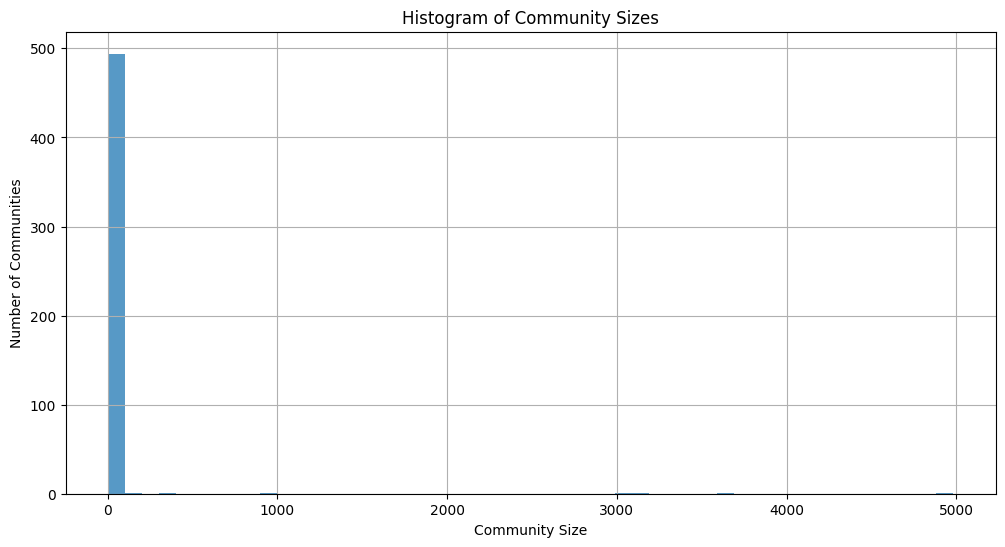

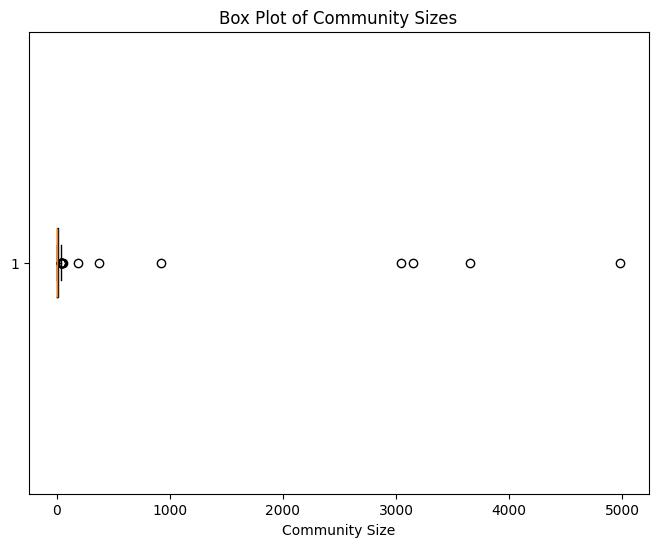

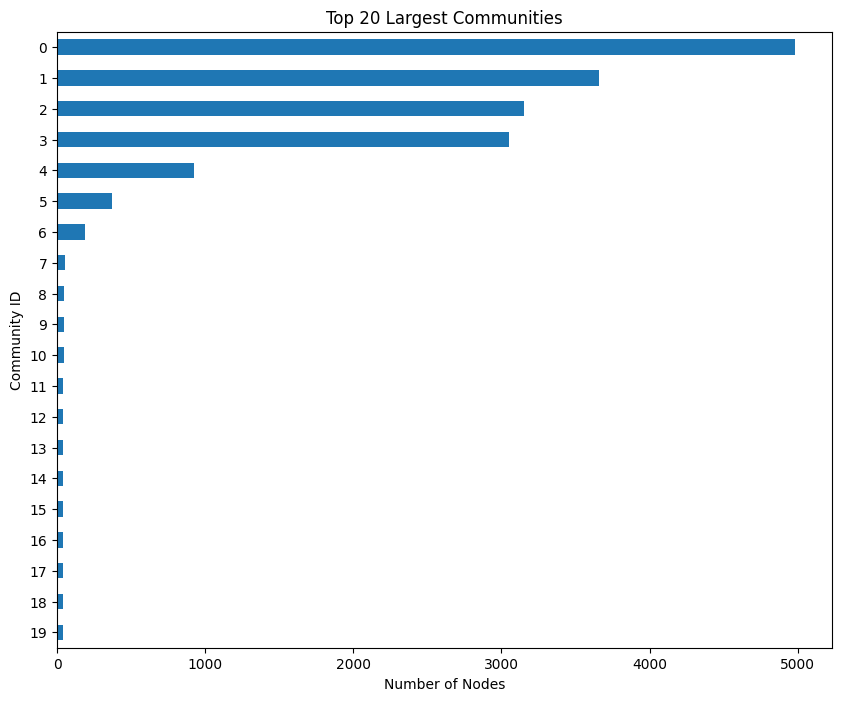

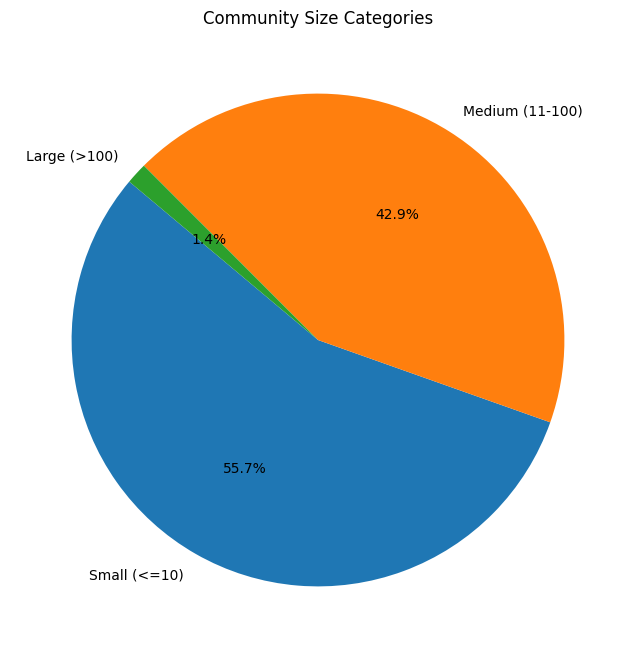

In [103]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the size of each community
community_sizes_louvain = node_df_louvain.groupby('communityID').size()

# Plot a histogram
plt.figure(figsize=(12, 6))
plt.hist(community_sizes_louvain, bins=50, alpha=0.75)
plt.title('Histogram of Community Sizes')
plt.xlabel('Community Size')
plt.ylabel('Number of Communities')
plt.grid(True)
plt.show()

# Plot a boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(community_sizes_louvain, vert=False)
plt.title('Box Plot of Community Sizes')
plt.xlabel('Community Size')
plt.show()

# Plot sizes of the top N communities
top_n = 20
top_communities = community_sizes_louvain.nlargest(top_n).sort_values()
top_communities.plot(kind='barh', figsize=(10, 8))
plt.title(f'Top {top_n} Largest Communities')
plt.xlabel('Number of Nodes')
plt.ylabel('Community ID')
plt.show()

# Plot pie chart
def categorize_size(x):
    if x <= 10:
        return 'Small (<=10)'
    elif x <= 100:
        return 'Medium (11-100)'
    else:
        return 'Large (>100)'

size_categories = community_sizes_louvain.apply(categorize_size).value_counts()

size_categories.plot(kind='pie', autopct='%1.1f%%', startangle=140, figsize=(8, 8))
plt.title('Community Size Categories')
plt.ylabel('')  # Hide the y-label as it's not informative for a pie chart
plt.show()

#### Community Content Analysis

In order to determine if the separation of entities into communities actually makes sense, we need to look at the internal components of communities.

In [104]:
community = node_df_louvain[node_df_louvain['communityID'] == 5]
# Count the occurrence of each type within the community
print(community['type'].value_counts())
# List all unique tags or artists within the community
print("Unique tags:", community[community['type'] == 'tag']['name'].unique())
print("Unique artists:", community[community['type'] == 'artist']['name'].unique())

type
artist    326
tag        33
user       15
Name: count, dtype: int64
Unique tags: ['rap' 'hip hop' 'gangsta rap' 'hip hop/rap' 'east coast rap'
 'alternative hip-hop' 'hardcore rap' 'west coast rap' 'deutschrap'
 'classic rap' 'funkalistic' 'old school hip hop' 'south rap' 'german rap'
 'best of hip hop' 'like rick ghraphixxx' 'best rapper alive'
 'funkalistik' 'german hip hop' 'my favourite rappers' 'white rap'
 'new york rap' 'hip hop classic' 'epitome of hip hop' 'chillil'
 'black rap' 'deutsch rap' 'lithuanian hip hop' 'punchlinerap'
 'best rapper ever' 'gansta rap' 'real rap' 'ultimate crap']
Unique artists: ['Nas' 'The Roots' '2Pac' 'Talib Kweli' 'Busta Rhymes' 'Vanilla Ice'
 'Dr. Dre' 'Mos Def' 'Wu-Tang Clan' 'Ice Cube' 'Notorious B.I.G.'
 '50 Cent' 'Raekwon' 'The Streets' 'Public Enemy' 'N.W.A' 'Fort Minor'
 'DMX' 'Mobb Deep' 'Snoop Dogg' 'Xzibit' 'Common' 'Ghostface Killah'
 'The Game' 'Rick GhraphiXxX' 'Azad' 'Andre 3000' 'Ludacris'
 'Bone Thugs-N-Harmony' 'Sonny Black & 

We can also look at the distribution of tags across communities, and whether there is a coherent thematic difference between communities. This is partial evidence for a successful detection of community structures.

In [105]:
# Filter out the tag-type nodes
tags_df_louvain = node_df_louvain[node_df_louvain['type'] == 'tag'].copy()

# Group by communityID and tag name, then count occurrences
tag_counts_by_community_louvain = tags_df_louvain.groupby(['communityID', 'name']).size().reset_index(name='count')

# Sort the results within each community by count, descending
tag_counts_by_community_sorted_louvain = tag_counts_by_community_louvain.sort_values(by=['communityID', 'count'], ascending=[True, False])

tag_counts_by_community_sorted_louvain

,communityID,name,count
0,0,00s rock,1
1,0,80s hardcore,1
2,0,80s songs not actually made in the 80s,1
3,0,80s y 90s,1
4,0,90210,1
...,...,...,...
1989,495,dark psy,1
1990,496,greek rock,1
1991,497,crossover thrash metal,1
1992,499,batcave deathrock,1


We ensure that we select 5 random communities that have at least 1 tag each, otherwise the visualization would not be complete. We look at the top tags in each of those communities to determine whether there are distinctions made.

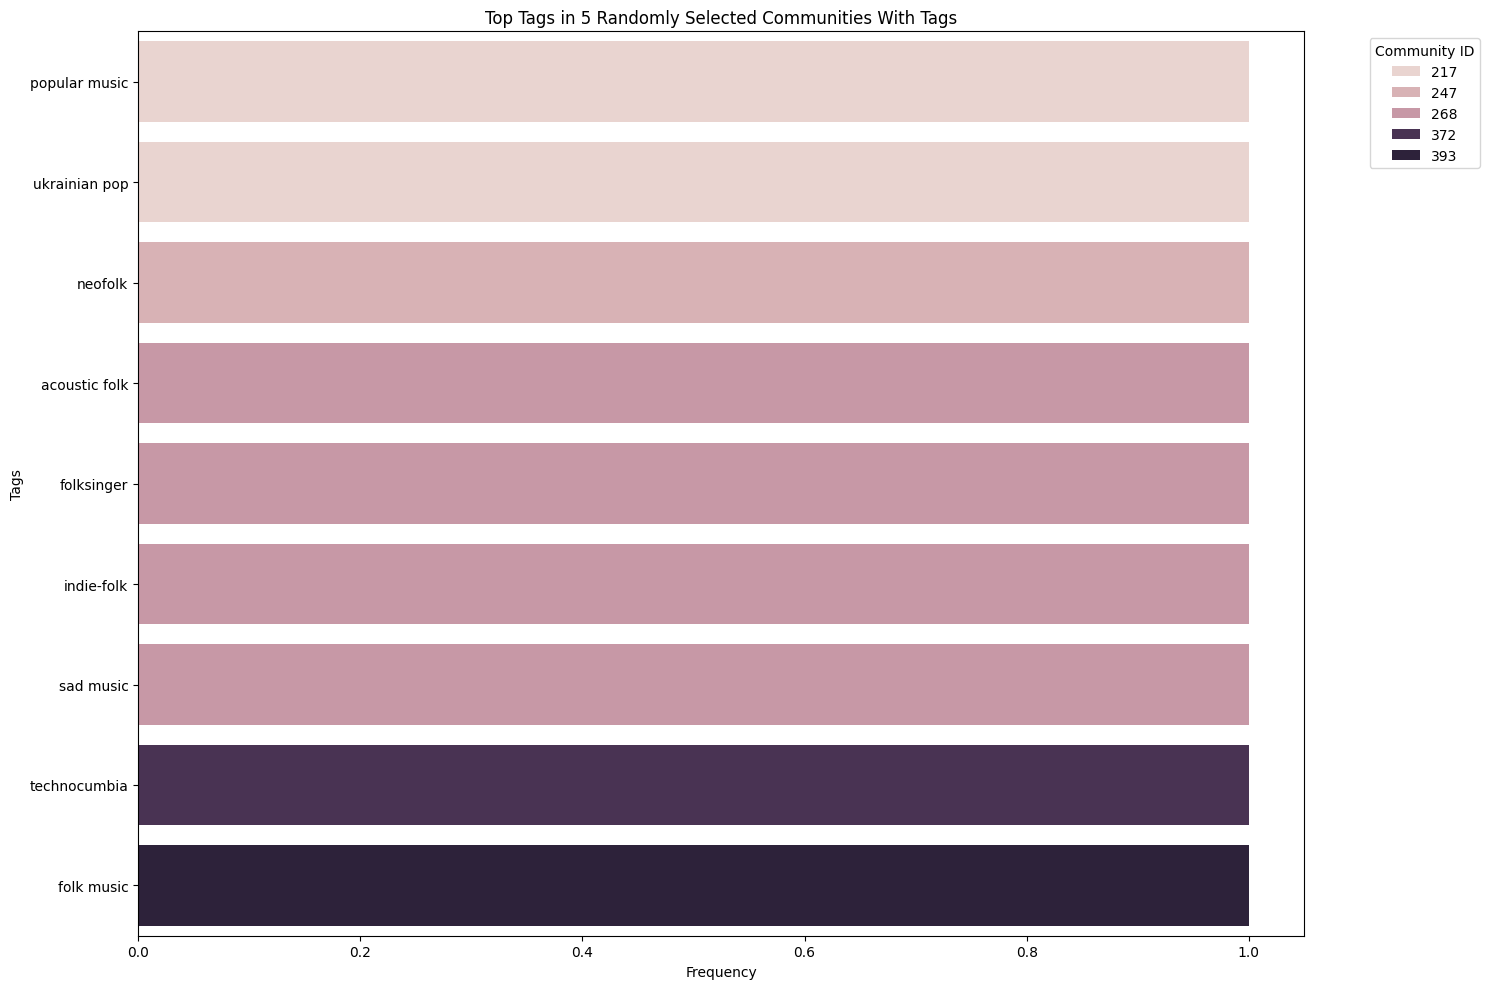

In [112]:
# For each community, select the top N tags to analyze
top_n = 5
top_tags_by_community_louvain = tag_counts_by_community_sorted_louvain.groupby('communityID').head(top_n)

# Set a seed for reproducibility
np.random.seed(999)

# Identify communities with at least one tag
communities_with_tags_louvain = tags_df_louvain['communityID'].unique()

# Check if we have at least 5 such communities
if len(communities_with_tags_louvain) >= 5:
    # Randomly select 5 communities that have at least one tag
    selected_communities = np.random.choice(communities_with_tags_louvain, 5, replace=False)
else:
    # If there are not enough communities with tags, just take what's available
    selected_communities = communities_with_tags_louvain

# Filter the top tags for these selected communities
selected_top_tags = top_tags_by_community_louvain[top_tags_by_community_louvain['communityID'].isin(selected_communities)]

import seaborn as sns

# Plot the top tags for the selected communities
plt.figure(figsize=(15, 10))
sns.barplot(x='count', y='name', hue='communityID', data=selected_top_tags, dodge=False)
plt.title('Top Tags in 5 Randomly Selected Communities With Tags')
plt.xlabel('Frequency')
plt.ylabel('Tags')
plt.legend(title='Community ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

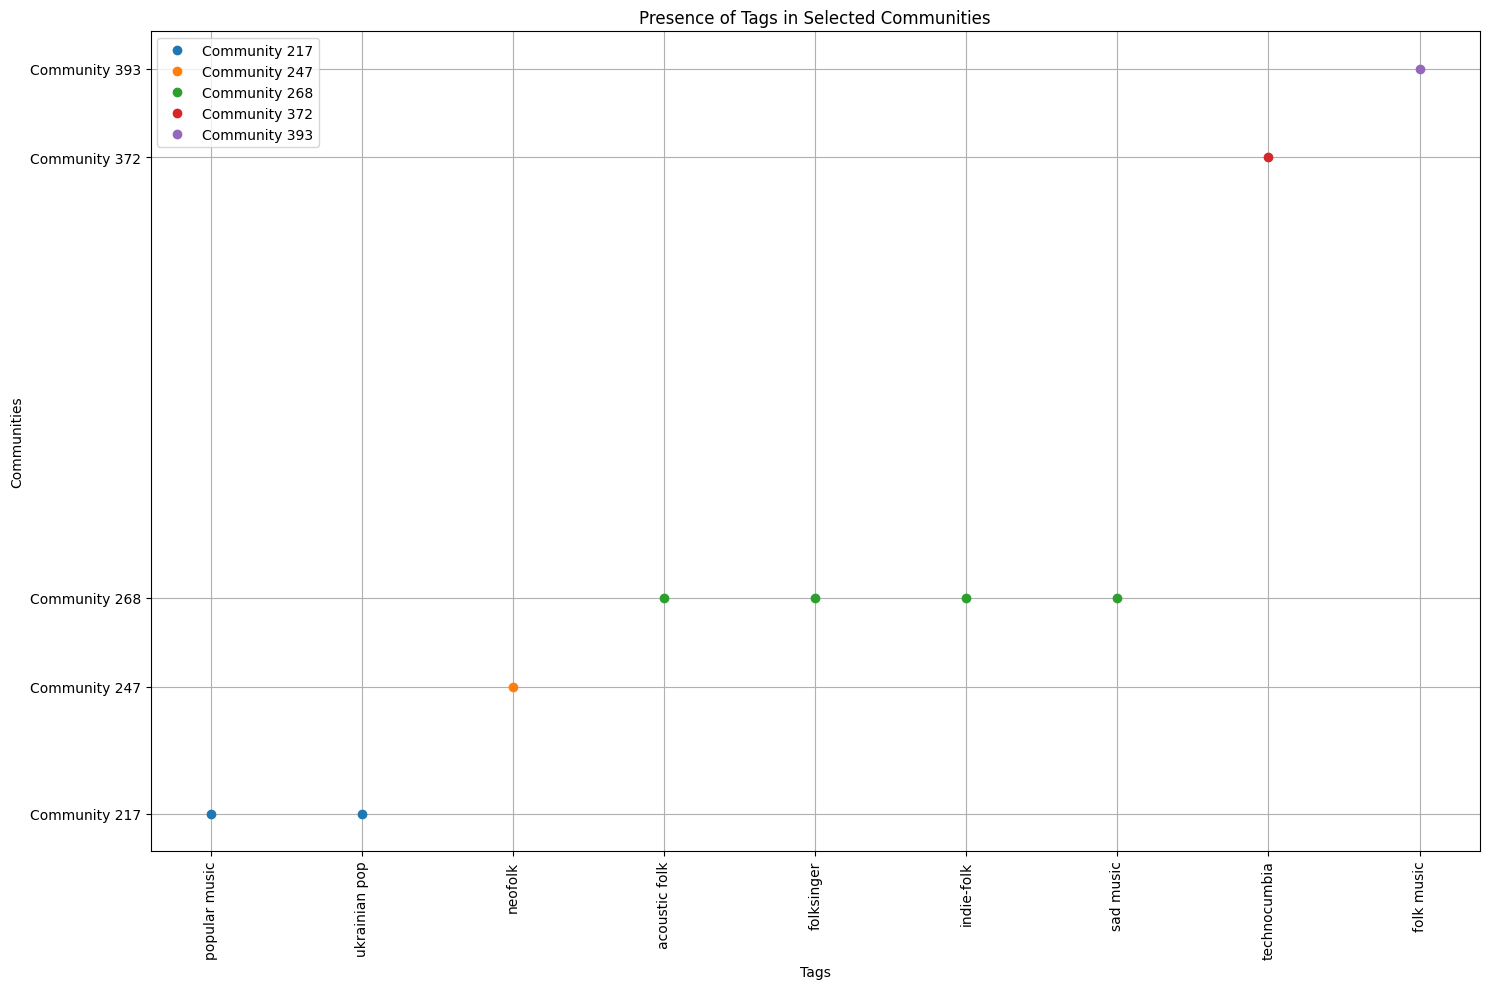

In [113]:
# Assuming 'selected_top_tags' contains the top tags for the selected communities
# Each tag is unique to a community, so we will visualize the presence of tags within communities

# Create a new figure and axis
plt.figure(figsize=(15, 10))
ax = plt.subplot()

# Get unique communities and tags for plotting
unique_communities_louvain = selected_top_tags['communityID'].unique()
unique_tags_louvain = selected_top_tags['name'].unique()

# Create a categorical plot
# For each community, we'll plot a line at y=1
for community in unique_communities_louvain:
    # Get the tags for this community
    community_tags = selected_top_tags[selected_top_tags['communityID'] == community]['name']
    # Plot each tag with a dot on the line
    ax.plot(community_tags, [community] * len(community_tags), 'o', label=f'Community {community}', linestyle='')

# Improve the plot aesthetics
ax.set_yticks(unique_communities_louvain)
ax.set_yticklabels([f'Community {id}' for id in unique_communities_louvain])
ax.set_ylabel('Communities')
ax.set_xlabel('Tags')
plt.title('Presence of Tags in Selected Communities')
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)  # Rotate x-axis labels to avoid overlap
plt.tight_layout()  # Adjust the padding between and around subplots

# Show the plot
plt.show()

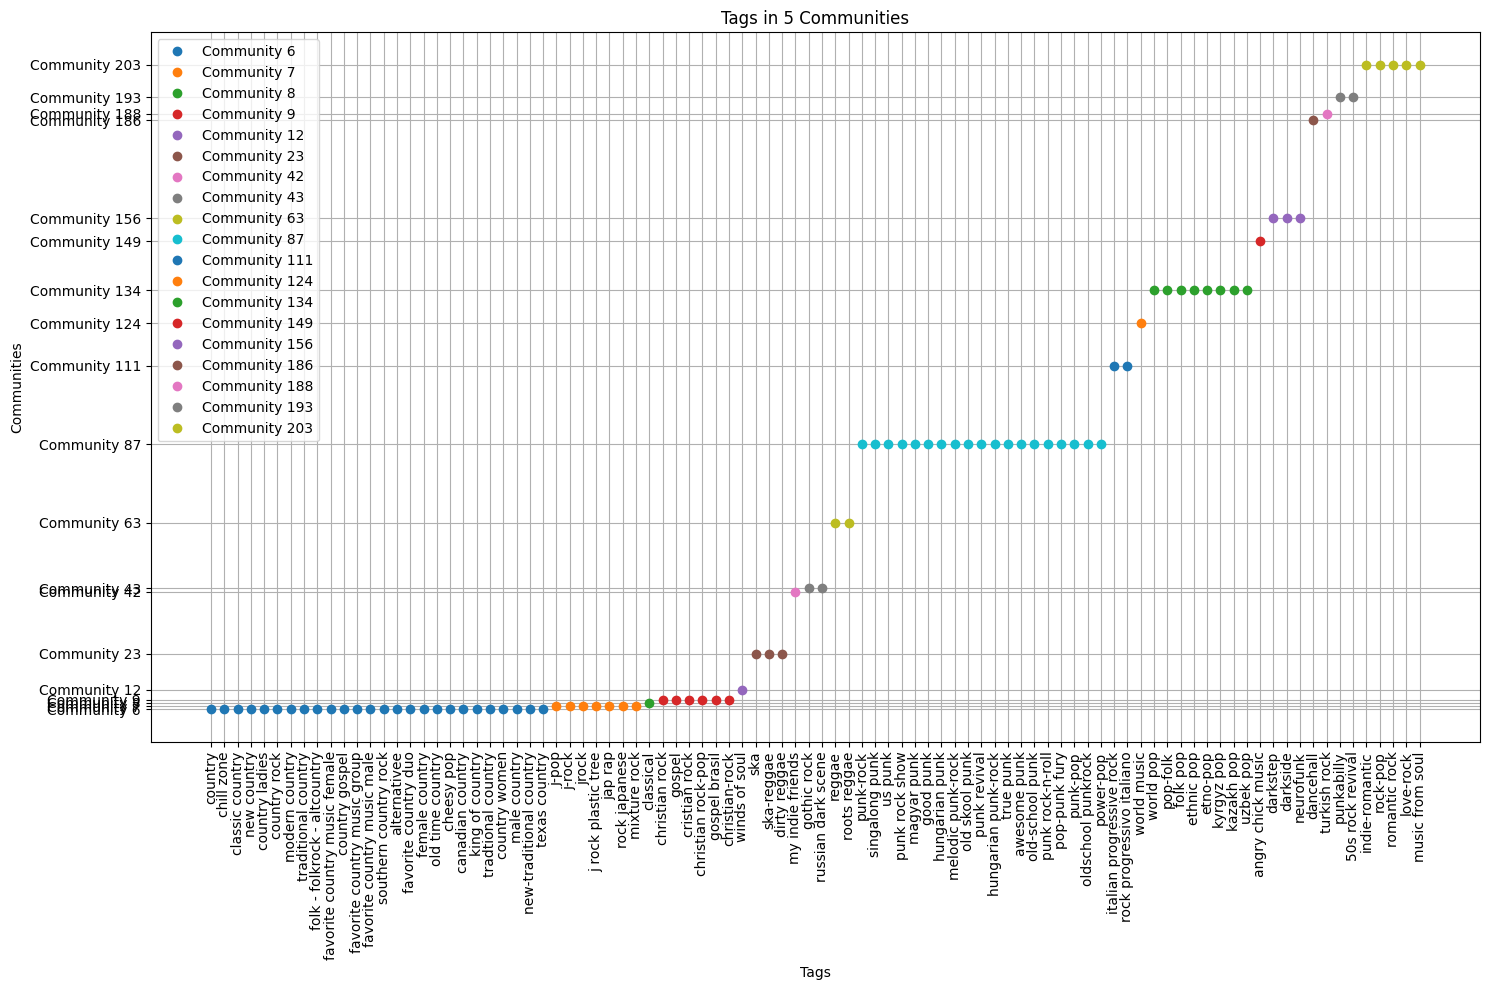

In [91]:
# Get the first 5 community IDs
first_5_communities = sorted(tags_df['communityID'].unique())[6:25]

# Filter tags from these communities
first_5_tags = tags_df[tags_df['communityID'].isin(first_5_communities)]

# Create a categorical plot to show the tags for each of the first 5 communities
plt.figure(figsize=(15, 10))
ax = plt.subplot()

# Plotting
for community in first_5_communities:
    # Get the tags for this community
    community_tags = first_5_tags[first_5_tags['communityID'] == community]['name']
    # Plot each tag with a dot on the line
    ax.plot(community_tags, [community] * len(community_tags), 'o', label=f'Community {community}', linestyle='')

# Improve the plot aesthetics
ax.set_yticks(first_5_communities)
ax.set_yticklabels([f'Community {id}' for id in first_5_communities])
ax.set_ylabel('Communities')
ax.set_xlabel('Tags')
plt.title('Tags in 5 Communities')
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)  # Rotate x-axis labels to avoid overlap
plt.tight_layout()  # Adjust the padding between and around subplots

# Show the plot
plt.show()

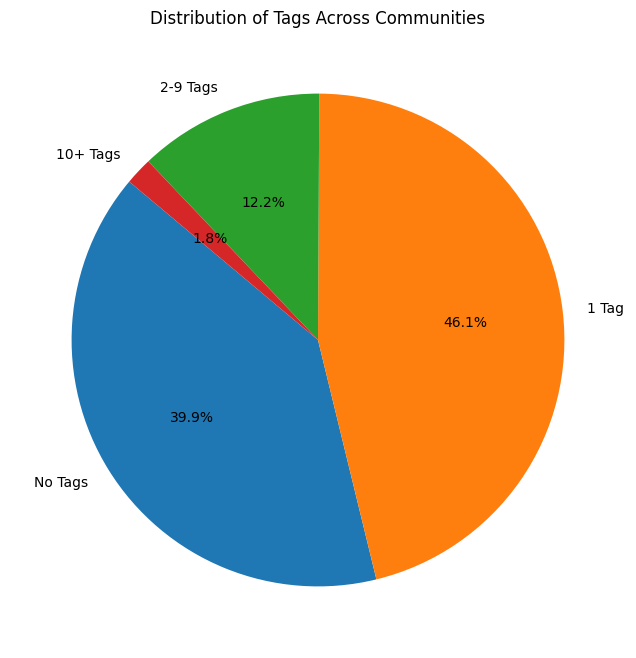

In [114]:
# Categorize each community by the number of tags it contains
counts = node_df_louvain[node_df_louvain['type'] == 'tag']['communityID'].value_counts()

# Define categories
no_tags = (counts == 0).sum()
one_tag = (counts == 1).sum()
less_than_ten_tags = ((counts > 1) & (counts < 10)).sum()
ten_or_more_tags = (counts >= 10).sum()

# Make sure to include communities with no tags
total_communities = node_df_louvain['communityID'].nunique()
no_tags = total_communities - len(counts)

# Prepare data for the pie chart
categories = ['No Tags', '1 Tag', '2-9 Tags', '10+ Tags']
sizes = [no_tags, one_tag, less_than_ten_tags, ten_or_more_tags]

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=categories, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Tags Across Communities')
plt.show()

### **For Leiden**

#### Overview of Community Data

First, we aggregate the data by community ID to get an overview of each community's composition. We group our DataFrame by the community ID and then examine the types and names within each community.


In [115]:
# Group by community ID and list out members of each community
community_groups = node_df_leiden.groupby('communityID')

# Example to print out the composition of each community
for community_id, group in community_groups:
    print(f"Community ID: {community_id}")
    print(f"Members count: {len(group)}")
    print(group[['nodeID', 'name', 'type']].head())  # Adjust as needed
    print("\n")


Community ID: 0
Members count: 4153
  nodeID              name type
0   t_73              rock  tag
2   t_79       alternative  tag
4   t_81             indie  tag
6   t_78  alternative rock  tag
7   t_25               80s  tag


Community ID: 1
Members count: 3853
   nodeID          name type
3    t_18    electronic  tag
5    t_33  experimental  tag
9    t_14       ambient  tag
11  t_187   electronica  tag
12   t_13      chillout  tag


Community ID: 2
Members count: 2928
   nodeID         name type
15  t_181         punk  tag
29  t_182    punk rock  tag
32  t_376    metalcore  tag
47  t_169     pop punk  tag
63   t_56  melancholic  tag


Community ID: 3
Members count: 2861
   nodeID        name    type
1    t_24         pop     tag
23  t_109    pop rock     tag
48  t_512    romantic     tag
55  t_199  electropop     tag
78   a_67     Madonna  artist


Community ID: 4
Members count: 2649
   nodeID              name type
17  t_192      classic rock  tag
19   t_83              jazz  tag

We can also get generate a summary table that lists each community ID along with the counts of tags, artists, and users in each community.

In [116]:
community_summary_leiden = node_df_leiden.groupby('communityID')['type'].value_counts().unstack(fill_value=0)

# Calculate the total number of entities in each community
community_summary_leiden['total_entities'] = community_summary_leiden.sum(axis=1)

# Reset the index to turn the index into a column
community_summary_leiden.reset_index(inplace=True)

# Display the summary table
community_summary_leiden

type,communityID,artist,tag,user,total_entities
0,0,3339,380,434,4153
1,1,3423,264,166,3853
2,2,2374,241,313,2928
3,3,2104,211,546,2861
4,4,2230,291,128,2649
5,5,1924,365,209,2498
6,6,1072,99,50,1221
7,7,519,56,19,594
8,8,465,44,22,531
9,9,88,10,2,100


#### Community Sizes

If we want to explore how the Louvain conducted its partitions, we can also review the sizes of the communities by:
- Normal histogram showing distirbution of size amongst communities, however, this isn't too clear.
- Box Plot could show where the majhority of communities exist in terms of size, and whether there are many outliers.
- A closer look at the 20 largest communities gives us an idea of their size.
- Pie Chart with a categorization of communities in small, medium and large.

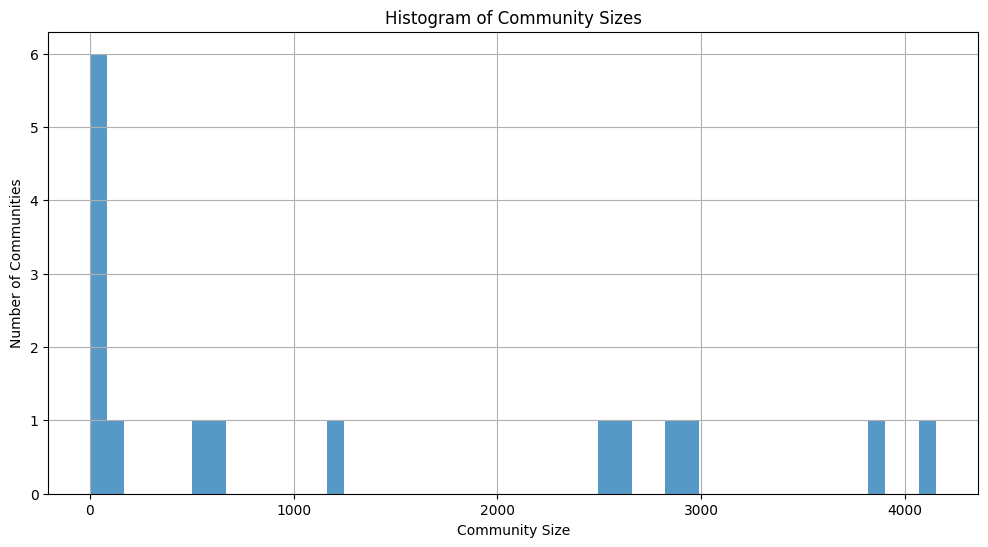

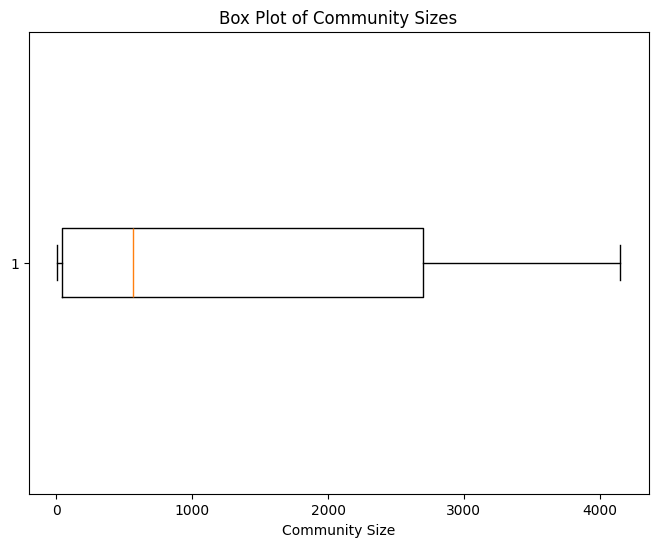

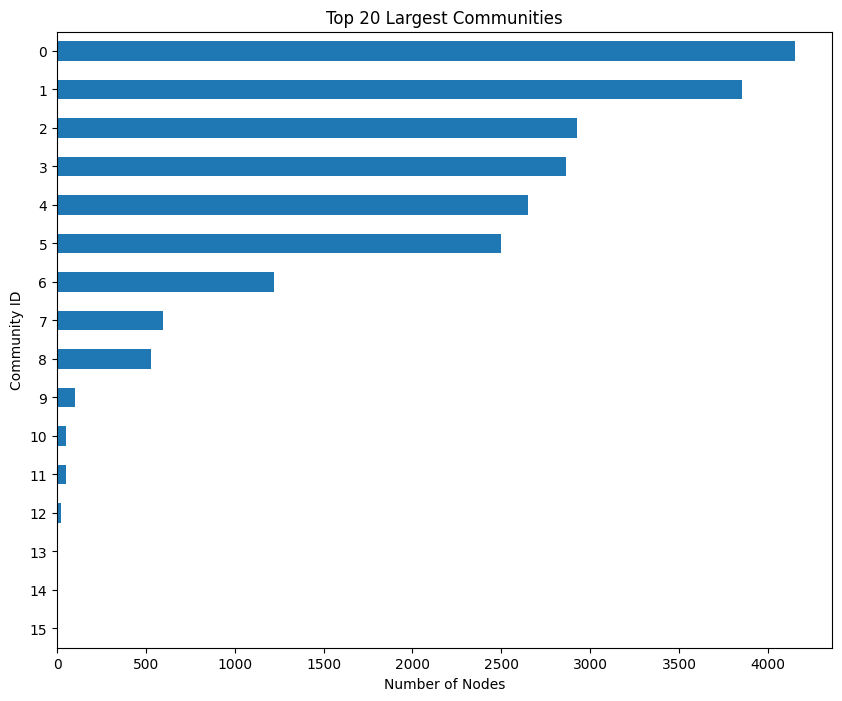

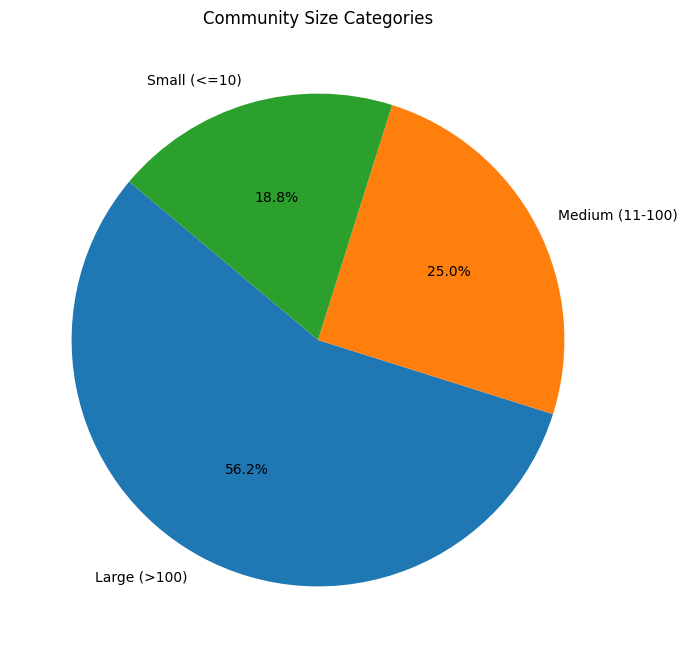

In [117]:
# Calculate the size of each community
community_sizes_leiden = node_df_leiden.groupby('communityID').size()

# Plot a histogram
plt.figure(figsize=(12, 6))
plt.hist(community_sizes_leiden, bins=50, alpha=0.75)
plt.title('Histogram of Community Sizes')
plt.xlabel('Community Size')
plt.ylabel('Number of Communities')
plt.grid(True)
plt.show()

# Plot a boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(community_sizes_leiden, vert=False)
plt.title('Box Plot of Community Sizes')
plt.xlabel('Community Size')
plt.show()

# Plot sizes of the top N communities
top_n = 20
top_communities = community_sizes_leiden.nlargest(top_n).sort_values()
top_communities.plot(kind='barh', figsize=(10, 8))
plt.title(f'Top {top_n} Largest Communities')
plt.xlabel('Number of Nodes')
plt.ylabel('Community ID')
plt.show()

# Plot pie chart
def categorize_size(x):
    if x <= 10:
        return 'Small (<=10)'
    elif x <= 100:
        return 'Medium (11-100)'
    else:
        return 'Large (>100)'

size_categories = community_sizes_leiden.apply(categorize_size).value_counts()

size_categories.plot(kind='pie', autopct='%1.1f%%', startangle=140, figsize=(8, 8))
plt.title('Community Size Categories')
plt.ylabel('')  # Hide the y-label as it's not informative for a pie chart
plt.show()

#### Specific Community Analysis

In [118]:
community = node_df_louvain[node_df_leiden['communityID'] == 8]
# Count the occurrence of each type within the community
print(community['type'].value_counts())
# List all unique tags or artists within the community
print("Unique tags:", community[community['type'] == 'tag']['name'].unique())
print("Unique artists:", community[community['type'] == 'artist']['name'].unique())

type
artist    465
tag        44
user       22
Name: count, dtype: int64
Unique tags: ['j-pop' 'j-rock' 'k-pop' 'jpop' 'jrock' 'kpop' 'japanese pop'
 'french pop' 'asian pop' 'jpop favorites' 'j-punk' 'j rock' 'korean rock'
 'chinese pop' 'japanese rock' 'wizard rock' 'melodic hard rock' 'hk-pop'
 'k-hip hop' 'rap eletronic' 'japanese trance' 'k-rap'
 'electronic - trance - psytrance'
 'j-pop japanese pop jpop female vocalists jazz japanese music j-rock'
 'j rock plastic tree' 'c-pop' 'korean pop' 'j-ska'
 'shinee ringdingdong kpop ring ding ding k-pop' 'mysterious'
 'jrock kawaiii'
 'j-pop japanese jpop pop female vocalists japan japanese music asian'
 'j-pop japanese jpop pop anime japan hip-hop female vocalists'
 'este disco me hace sentir un orgasmo'
 'j-pop japanese jpop pop anime j-rock female vocalists japanese music'
 'j rock indie' 'jap rap' 'rock japanese' 'j  rock' 'rock steady baby'
 'cpop' 'mixture rock' 'alternative hip hop' 'henrylaurocks']
Unique artists: ['安室奈美恵' '浜崎あゆ

We can also look at the distribution of tags across communities, and whether there is a coherent thematic difference between communities. This is partial evidence for a successful detection of community structures.

In [119]:
# Filter out the tag-type nodes
tags_df_leiden = node_df_leiden[node_df_leiden['type'] == 'tag'].copy()

# Group by communityID and tag name, then count occurrences
tag_counts_by_community_leiden = tags_df.groupby(['communityID', 'name']).size().reset_index(name='count')

# Sort the results within each community by count, descending
tag_counts_by_community_sorted_leiden = tag_counts_by_community_leiden.sort_values(by=['communityID', 'count'], ascending=[True, False])

tag_counts_by_community_sorted_leiden

,communityID,name,count
0,0,00s rock,1
1,0,80s hardcore,1
2,0,80s songs not actually made in the 80s,1
3,0,80s y 90s,1
4,0,90210,1
...,...,...,...
1989,495,dark psy,1
1990,496,greek rock,1
1991,497,crossover thrash metal,1
1992,499,batcave deathrock,1


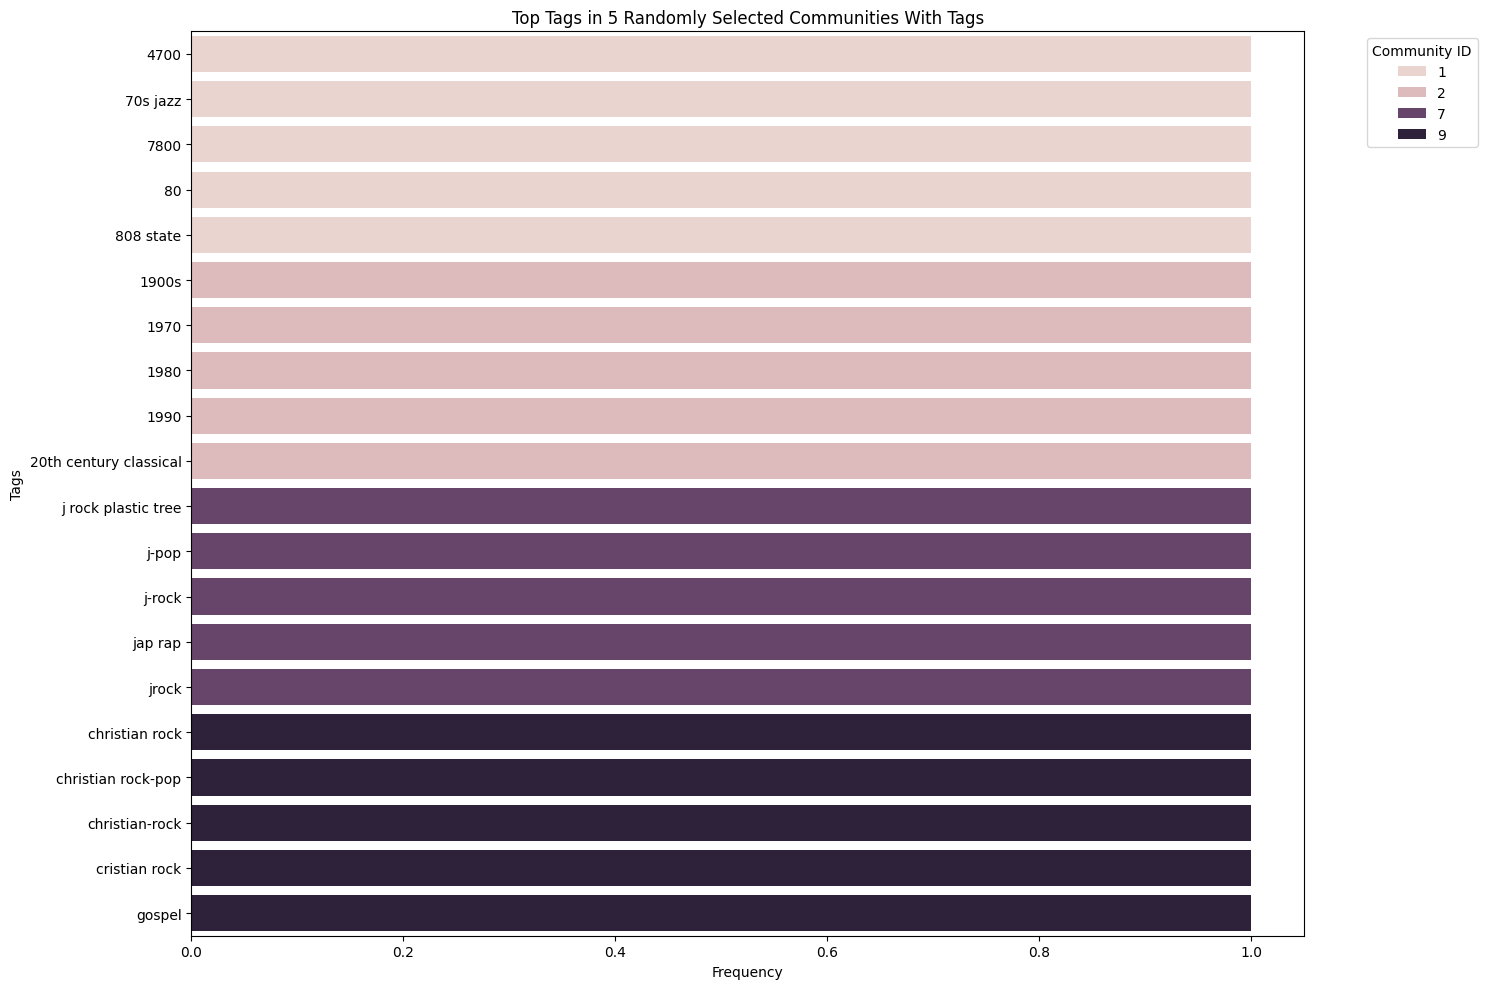

In [122]:
# For each community, select the top N tags to analyze
top_n = 5
top_tags_by_community_leiden = tag_counts_by_community_sorted_leiden.groupby('communityID').head(top_n)

# Set a seed for reproducibility
np.random.seed(999)

# Identify communities with at least one tag
communities_with_tags_leiden = tags_df_leiden['communityID'].unique()

# Check if we have at least 5 such communities
if len(communities_with_tags_leiden) >= 5:
    # Randomly select 5 communities that have at least one tag
    selected_communities_leiden = np.random.choice(communities_with_tags_leiden, 5, replace=False)
else:
    # If there are not enough communities with tags, just take what's available
    selected_communities_leiden = communities_with_tags_leiden

# Filter the top tags for these selected communities
selected_top_tags_leiden = top_tags_by_community_leiden[top_tags_by_community_leiden['communityID'].isin(selected_communities_leiden)]

import seaborn as sns

# Plot the top tags for the selected communities
plt.figure(figsize=(15, 10))
sns.barplot(x='count', y='name', hue='communityID', data=selected_top_tags_leiden, dodge=False)
plt.title('Top Tags in 5 Randomly Selected Communities With Tags')
plt.xlabel('Frequency')
plt.ylabel('Tags')
plt.legend(title='Community ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

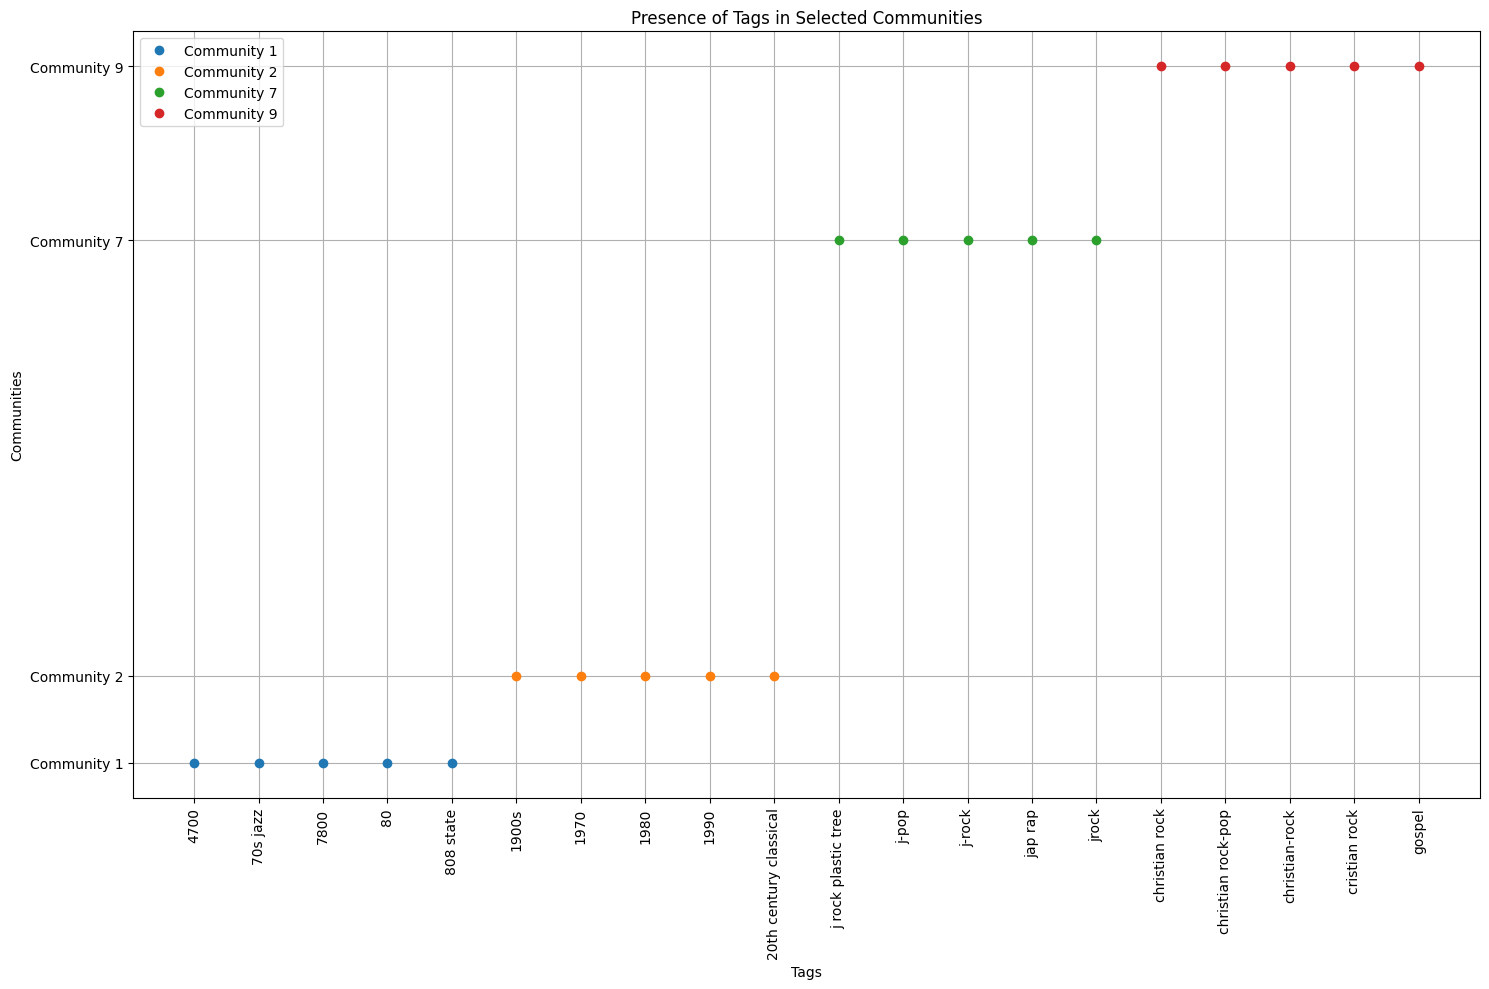

In [123]:
# Assuming 'selected_top_tags' contains the top tags for the selected communities
# Each tag is unique to a community, so we will visualize the presence of tags within communities

# Create a new figure and axis
plt.figure(figsize=(15, 10))
ax = plt.subplot()

# Get unique communities and tags for plotting
unique_communities_leiden = selected_top_tags_leiden['communityID'].unique()
unique_tags_leiden = selected_top_tags_leiden['name'].unique()

# Create a categorical plot
# For each community, we'll plot a line at y=1
for community in unique_communities_leiden:
    # Get the tags for this community
    community_tags = selected_top_tags[selected_top_tags_leiden['communityID'] == community]['name']
    # Plot each tag with a dot on the line
    ax.plot(community_tags, [community] * len(community_tags), 'o', label=f'Community {community}', linestyle='')

# Improve the plot aesthetics
ax.set_yticks(unique_communities_leiden)
ax.set_yticklabels([f'Community {id}' for id in unique_communities_leiden])
ax.set_ylabel('Communities')
ax.set_xlabel('Tags')
plt.title('Presence of Tags in Selected Communities')
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)  # Rotate x-axis labels to avoid overlap
plt.tight_layout()  # Adjust the padding between and around subplots

# Show the plot
plt.show()

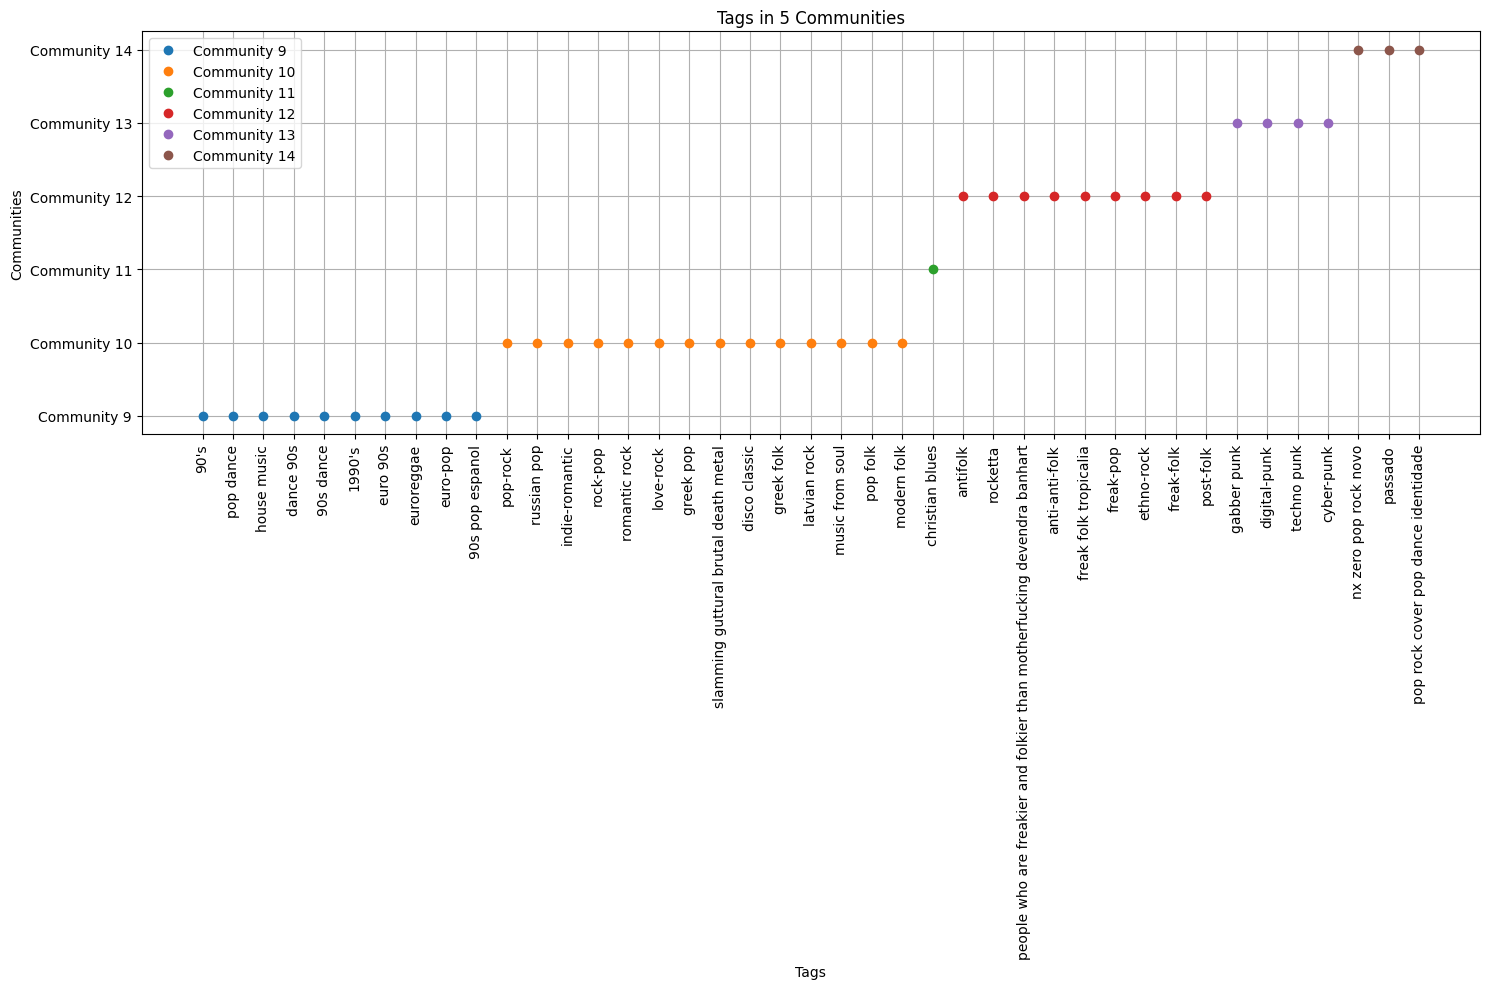

In [131]:
# Get the first 5 community IDs
first_5_communities = sorted(tags_df_leiden['communityID'].unique())[9:15]

# Filter tags from these communities
first_5_tags = tags_df_leiden[tags_df_leiden['communityID'].isin(first_5_communities)]

# Create a categorical plot to show the tags for each of the first 5 communities
plt.figure(figsize=(15, 10))
ax = plt.subplot()

# Plotting
for community in first_5_communities:
    # Get the tags for this community
    community_tags = first_5_tags[first_5_tags['communityID'] == community]['name']
    # Plot each tag with a dot on the line
    ax.plot(community_tags, [community] * len(community_tags), 'o', label=f'Community {community}', linestyle='')

# Improve the plot aesthetics
ax.set_yticks(first_5_communities)
ax.set_yticklabels([f'Community {id}' for id in first_5_communities])
ax.set_ylabel('Communities')
ax.set_xlabel('Tags')
plt.title('Tags in 5 Communities')
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)  # Rotate x-axis labels to avoid overlap
plt.tight_layout()  # Adjust the padding between and around subplots

# Show the plot
plt.show()

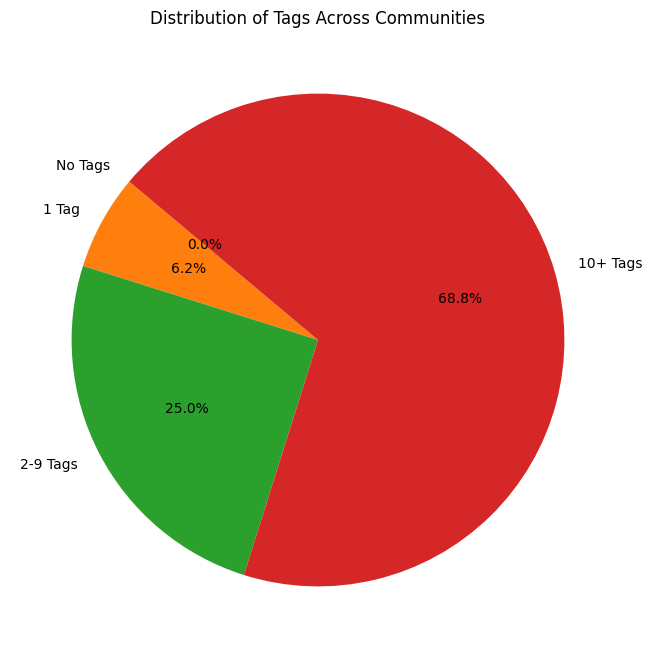

In [132]:
# Categorize each community by the number of tags it contains
counts = node_df_leiden[node_df_leiden['type'] == 'tag']['communityID'].value_counts()

# Define categories
no_tags = (counts == 0).sum()
one_tag = (counts == 1).sum()
less_than_ten_tags = ((counts > 1) & (counts < 10)).sum()
ten_or_more_tags = (counts >= 10).sum()

# Make sure to include communities with no tags
total_communities = node_df_leiden['communityID'].nunique()
no_tags = total_communities - len(counts)

# Prepare data for the pie chart
categories = ['No Tags', '1 Tag', '2-9 Tags', '10+ Tags']
sizes = [no_tags, one_tag, less_than_ten_tags, ten_or_more_tags]

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=categories, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Tags Across Communities')
plt.show()